In [1]:
import rdkit

import pandas as pd
import numpy as np
from copy import deepcopy

from torch_geometric.datasets import MoleculeNet
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem

In [2]:
import custom_classification_functions
import custom_models
from custom_classification_functions import *
from custom_models import *
import custom_general_functions
from custom_general_functions import *

In [3]:
import dgl_functions
from dgl_functions import *
import dgl_models
from dgl_models import *

In [4]:
data, data_y = load_hiv()

dgl_graph_list = create_dgl_graph(data, data_y)

processed_data = process_dgl_graph(dgl_graph_list)

train_dataset, test_dataset, val_dataset = create_train_test_graphs(processed_data, train_percentage= 0.8, apply_scaffold_split = False )

loader, test_loader = create_dgl_dataloader(train_dataset, test_dataset, batch_size=64)

In [5]:
model, device, optimizer, loss_fn = initialize_dgl_classification_model(in_feats=train_dataset[0][0].ndata["h"].shape[-1], hidden_feats=None, gnn_norm=None, activation=None, residual=None, batchnorm=None, dropout=None, classifier_hidden_feats=128, classifier_dropout=0.0, n_tasks=1, predictor_hidden_feats=128, predictor_dropout=0.0)

GCNPredictor(
  (gnn): GCN(
    (gnn_layers): ModuleList(
      (0): GCNLayer(
        (graph_conv): GraphConv(in=74, out=64, normalization=none, activation=<function relu at 0x000001BC375E5E50>)
        (dropout): Dropout(p=0.0, inplace=False)
        (res_connection): Linear(in_features=74, out_features=64, bias=True)
        (bn_layer): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): GCNLayer(
        (graph_conv): GraphConv(in=64, out=64, normalization=none, activation=<function relu at 0x000001BC375E5E50>)
        (dropout): Dropout(p=0.0, inplace=False)
        (res_connection): Linear(in_features=64, out_features=64, bias=True)
        (bn_layer): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (readout): WeightedSumAndMax(
    (weight_and_sum): WeightAndSum(
      (atom_weighting): Sequential(
        (0): Linear(in_features=64, out_features=1, bias=True)
        (1): Sigmoid(

Epoch 0 | Train Loss 0.24854300078547117 | Validation Loss 0.16587090324754863 | Validation accuracy 0.9660852713178295
Epoch 10 | Train Loss 0.12091295956407935 | Validation Loss 0.13109747064841348 | Validation accuracy 0.9652516529867761
Epoch 20 | Train Loss 0.11278956336448494 | Validation Loss 0.1270196012315131 | Validation accuracy 0.9673392612859096
Epoch 30 | Train Loss 0.10299761320636111 | Validation Loss 0.11903501488990331 | Validation accuracy 0.9688853739170087
Epoch 40 | Train Loss 0.09583918866746634 | Validation Loss 0.12795849206546941 | Validation accuracy 0.969234496124031
Epoch 50 | Train Loss 0.09063620662081588 | Validation Loss 0.14025152923698112 | Validation accuracy 0.9685077519379846
Epoch 60 | Train Loss 0.08551902682023141 | Validation Loss 0.1270246766146648 | Validation accuracy 0.9686573757409941
Epoch 70 | Train Loss 0.08270396961496003 | Validation Loss 0.1272644195272479 | Validation accuracy 0.9693556201550387
patience 0


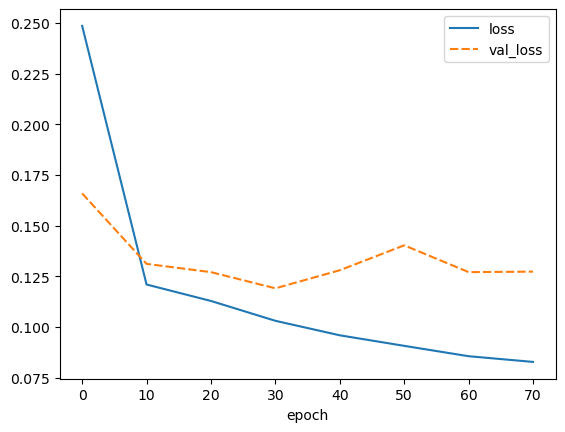

In [6]:
model, best_model_weights, losses, val_losses = classification_dgl_train(model, loader, test_loader, device, loss_fn, optimizer, log_time=10, max_epochs=1000, apply_early_stopping = True, early_stopping_patience = 50, finally_plot_losses = True)

In [13]:
def predict_dgl_classification(model, test_loader, device, plot_final = True, plot_label="precision-recall curve"):


    dfs = []

    test_true_labels = []
    test_predicted_labels = []
    for test_batch, test_labels in test_loader:
        with torch.no_grad():
            test_true_labels.extend(test_labels)

            test_labels = test_labels.float()
            test_labels = test_labels.unsqueeze(dim=1)
            test_labels = test_labels.to(device)
            test_batch = test_batch.to(device)  
            test_batch_dgl_data = test_batch.ndata['h'].float()

            pred= model(test_batch, test_batch_dgl_data) 
            #test_batch.to(device)
            #pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
            df = pd.DataFrame()
            df["y_real"] = test_labels.tolist()
            df["y_pred"] = pred.tolist()

            df["y_real"] = df["y_real"].apply(lambda row: row[0])
            df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
            dfs.append(df)

            test_predicted_labels.extend(pred.tolist())


    precisions, recalls, thresholds = precision_recall_curve(np.array(test_true_labels).flatten(), np.array(test_predicted_labels).flatten(), drop_intermediate=True)

    if plot_final:
        plt.plot(recalls, precisions)
        plt.xlabel("recall")
        plt.ylabel("precision")
        plt.title(plot_label)


    return precisions, recalls, thresholds, dfs



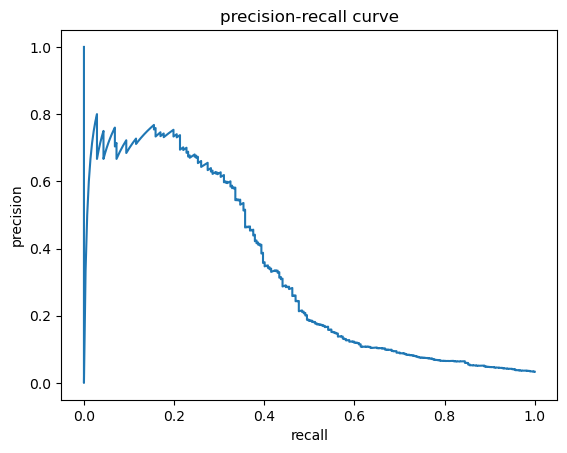

In [14]:
precisions, recalls, thresholds, dfs = predict_dgl_classification(model, test_loader, device, plot_final = True, plot_label="precision-recall curve")